# Forecasting: ARIMA

From [Investopedia](http://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp):
    
> A statistical analysis model that uses time series data to predict future trends. It is a form of regression analysis that seeks to predict future movements along the seemingly random walk taken by stocks and the financial market by examining the differences between values in the series instead of using the actual data values. Lags of the differenced series are referred to as "autoregressive" and lags within forecasted data are referred to as "moving average."

### Data Preparation

We will use historical data of CO<sub>2</sub> levels, included in `statsmodel` package.

In [1]:
import pandas as pd
import statsmodels.api as sm
dataset = sm.datasets.co2.load().data

The series have some missing values, we should compute monthly averages first:

In [2]:
monthly_avg = dataset.co2.resample('MS').mean()
monthly_avg[:5]

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [3]:
data = monthly_avg.fillna(monthly_avg.bfill())
data[:5]

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['font.family'] = 'IBM Plex Mono'

<AxesSubplot:>

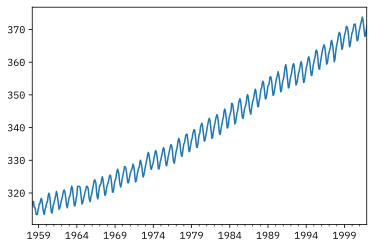

In [5]:
data.plot()

## Model parameters

ARIMA is a model governed by 3 parameters:

- `p`, to consider past values in our model.
- `d`, to consider latest differences when asserting current state.
- `q`, to consider errors in the model.

It's easy to observe that C0<sub>2</sub> values follow a _seasonality_ pattern, probably different in summer and winter. To deal with _seasonal_ effects we add another 3 components to the model `(P, D, Q)` that would be only applied to the seasonal component of the time series. Also, there's a 4th parameter called `s` to define the periodicity of the time series:

```
ARIMA(p,d,q)(P,D,Q)s
```

Big question is, what are the values we have to pick for each one of the parameters? For this exercise we'll magicaly pick the parameters, you might check [this R functions](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) to perform a proper auto-evaluation:

```
ARIMA(1,1,1)(1,1,1)12
```

That model can be fitted using `SARIMAX` function from `statsmodel` package.

In [6]:
model = sm.tsa.statespace.SARIMAX(data, 
    order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
    enforce_stationarity=False, enforce_invertibility=False)

result = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01

At iterate    5    f=  2.76115D-01    |proj g|=  4.65690D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41838D-02

At iterate   15    f=  2.54556D-01    |proj g|=  8.27276D-03

At iterate   20    f=  2.54547D-01    |proj g|=  4.40094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     48      1     0     0   1.911D-03   2.545D-01
  F =  0.25454407836845344     

CONVERG

The important value here is the `P > |z|` one.

In [7]:
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3182,0.092,3.444,0.001,0.137,0.499
ma.L1,-0.6256,0.077,-8.174,0.000,-0.776,-0.476
ar.S.L12,0.0010,0.001,1.732,0.083,-0.000,0.002
ma.S.L12,-0.8766,0.026,-33.747,0.000,-0.928,-0.826
sigma2,0.0972,0.004,22.627,0.000,0.089,0.106


The fitting results can be also plotted:

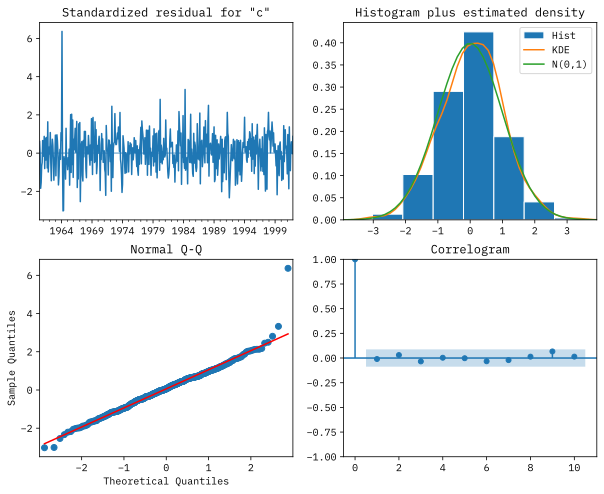

In [8]:
import matplotlib.pyplot as plt
result.plot_diagnostics(figsize=(10, 8))
plt.show()

## Predicting Values

Now the fun part, can we use the computed model to predict the future?

Let's see if we can _predict past past values_ first.

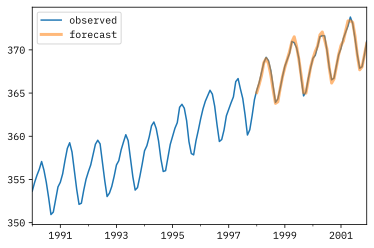

In [9]:
import pandas as pd
past_prediction = result.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)

data['1990':].plot(label="observed")
past_prediction.predicted_mean.plot(label="forecast", linewidth=3, alpha=0.55)
plt.legend()

The function to predict future values is called `get_forecast()`.

In [10]:
prediction = result.get_forecast(steps=300)
prediction.predicted_mean[:3]

2002-01-01    371.977669
2002-02-01    372.749139
2002-03-01    373.662283
Freq: MS, Name: predicted_mean, dtype: float64

In [11]:
prediction.summary_frame()[:3]

co2,mean,mean_se,mean_ci_lower,mean_ci_upper
2002-01-01,371.977669,0.311730,371.366690,372.588649
2002-02-01,372.749139,0.379188,372.005944,373.492335
2002-03-01,373.662283,0.422084,372.835014,374.489552


We will add the confident interval provided by `conf_int()` to the graph. Intuitivelly the prediction is _weaker_ as we evolve in time.

In [12]:
ci = prediction.conf_int()
ci[:3]

,lower co2,upper co2
2002-01-01,371.366690,372.588649
2002-02-01,372.005944,373.492335
2002-03-01,372.835014,374.489552


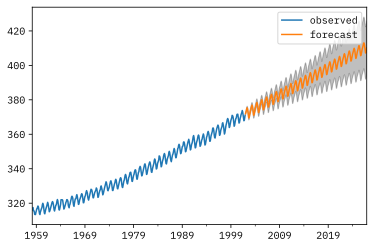

In [13]:
ax = data.plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()

**Conclusion**: leave your car at home and buy a bicycle.

---

_This notebook was adapted from the work made by [Thomas Vicent](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3) under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0) license and therefore it's licensed under the same terms._